<p align="center">
<img src="https://github.com/datacamp/python-live-training-template/blob/master/assets/datacamp.svg?raw=True" alt = "DataCamp icon" width="50%">
</p>
<br><br>

## **Cleaning Data with Pyspark**

Welcome to this hands-on training where we will investigate cleaning a dataset using Python and Apache Spark! During this training, we will cover:

* Efficiently loading data into a Spark DataFrame
* Handling errant rows / columns from the dataset, including comments, missing data, combined or misinterpreted columns, etc.
* Using Python UDFs to run advanced transformations on data


## **The Dataset**

The dataset used in this webinar is a set of CSV files named `netflix_titles_raw*.csv`. These contain information related to the movies and television shows available on Netflix. These are the *dirty* versions of the dataset - we will cover the individual problems as we work through the notebook.

Given that this is a data cleaning webinar, let's look at our intended result.  The dataset will contain the follwing information:

- `show_id`: A unique integer identifier for the show
- `type`: The type of content, `Movie` or `TV Show`
- `title`: The title of the content
- `director`: The director (or directors)
- `cast`: The cast
- `country`: Country (or countries) where the content is available
- `date_added`: Date added to Netflix
- `release_year`: Year of content release
- `rating`: Content rating
- `duration`: The duration
- `listed_in`: The genres the content is listed in
- `description`: A description of the content



## **Setting up a PySpark session**

Before we can start processing our data, we need to configure a Pyspark session for Google Colab. Note that this is specific for using Spark and Python in Colab and likely is not required for other environments. 

In [20]:
# Run this code as is to install Spark in Colab
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
!tar xf spark-2.4.8-bin-hadoop2.7.tgz
!pip install -q findspark

In [21]:
# Finally, setup our Spark session
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.8-bin-hadoop2.7"
import findspark
findspark.init()
from google.colab import files
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import isnan, when, count, col, lit, trim, avg, ceil
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## **Getting started**

Before doing anything else, lets copy our data files locally. We'll be using `wget`, `ls`, `gunzip`, and `head`, which are normally shell commands. In the notebook environment, we can run any given shell command using the precursor `!`. The purpose of our shell commands are as follows:

- `wget` - Is an HTTP client that will download our data files and save them locally in our notebook environment.
- `ls` - Used to list the files in a directory.
- `gunzip` - Our data files are compressed using the `gzip` compression format. `gunzip` allows us to decompress those files.
- `head` - Much like the `.head()` command in Pandas, the shell command `head` defaults to printing out the first 10 lines of a file. You can specify more or fewer lines if desired. 

This is an example of some of these commands being executed in a traditional shell environment:

![Shell Commands](https://github.com/datacamp/data-cleaning-with-pyspark-live-training/raw/master/assets/SparkLiveTraining-shellcommands.png)

Let's run the follwing cell to pull the *dirty* files locally. We'll be writing the files to the `/tmp` directory in the notebook environment.

In [22]:
# Copy our dataset locally

!wget https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv -O features.csv
!wget https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv -O labels.csv

--2021-11-05 08:21:18--  https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.128.205
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.128.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20069199 (19M) [text/csv]
Saving to: ‘features.csv’

features.csv        100%[===================>]  19.14M  34.9MB/s    in 0.5s    

2021-11-05 08:21:19 (34.9 MB/s) - ‘features.csv’ saved [20069199/20069199]

--2021-11-05 08:21:19--  https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.128.205
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.128.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1148327 (1.1M) [text/csv]
Saving to: ‘labels.csv’

labels.csv          100%[===================>]   1.09M  5.20MB/s    in 0.2s    

2021-11-05 08:21:20 

**Now, let's verify that we have all 7 files we expect**

Let's use the `ls` command to list files in the `/tmp` directory. Note that the `*` here is a wildcard, meaning match anything. Specifically, we're looking for `netflix_titles*`, which is match any file or directory that starts with `netflix_titles`.

In [23]:
!ls

features.csv  sample_data		 spark-2.4.8-bin-hadoop2.7.tgz
labels.csv    spark-2.4.8-bin-hadoop2.7  spark-2.4.8-bin-hadoop2.7.tgz.1


In [24]:
sc = SparkSession.builder.master("local[*]").getOrCreate()

In [44]:
feature = sc.read.csv("features.csv", inferSchema=True,header=True)
label = sc.read.csv("labels.csv", inferSchema=True , header=True)

In [45]:
print(feature.count())
print(label.count())
print(feature.columns)
print(label.columns)

59400
59400
['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']
['id', 'status_group']


In [46]:
data = feature.join(label, on="id")
print(data.count())
print(data.columns)

59400
['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']


In [28]:
#Changing data types removing whitespaces

In [47]:
print(data.printSchema())
print(data.show(10))

root
 |-- id: integer (nullable = true)
 |-- amount_tsh: double (nullable = true)
 |-- date_recorded: timestamp (nullable = true)
 |-- funder: string (nullable = true)
 |-- gps_height: integer (nullable = true)
 |-- installer: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- wpt_name: string (nullable = true)
 |-- num_private: integer (nullable = true)
 |-- basin: string (nullable = true)
 |-- subvillage: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_code: integer (nullable = true)
 |-- district_code: integer (nullable = true)
 |-- lga: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- public_meeting: boolean (nullable = true)
 |-- recorded_by: string (nullable = true)
 |-- scheme_management: string (nullable = true)
 |-- scheme_name: string (nullable = true)
 |-- permit: boolean (nullable = true)
 |-- construction_year: integer (nullable

In [30]:
""" We have region_code: integer (nullable = true)
 |-- district_code: integer (nullable = true) which should be categorical type otherwise it will impact 
      machine learning model"""

' We have region_code: integer (nullable = true)\n |-- district_code: integer (nullable = true) which should be categorical type otherwise it will impact \n      machine learning model'

In [48]:
# Changing Data type to categorical

data = data.withColumn("region_code",col('region_code').cast(StringType())).withColumn('district_code',col('district_code').cast(StringType()))

In [49]:
data.printSchema()    #now region code and district code has been changed to string 

root
 |-- id: integer (nullable = true)
 |-- amount_tsh: double (nullable = true)
 |-- date_recorded: timestamp (nullable = true)
 |-- funder: string (nullable = true)
 |-- gps_height: integer (nullable = true)
 |-- installer: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- wpt_name: string (nullable = true)
 |-- num_private: integer (nullable = true)
 |-- basin: string (nullable = true)
 |-- subvillage: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_code: string (nullable = true)
 |-- district_code: string (nullable = true)
 |-- lga: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- public_meeting: boolean (nullable = true)
 |-- recorded_by: string (nullable = true)
 |-- scheme_management: string (nullable = true)
 |-- scheme_name: string (nullable = true)
 |-- permit: boolean (nullable = true)
 |-- construction_year: integer (nullable =

In [50]:
# dropping duplicate values

data = data.dropDuplicates(['id'])
data.count()

59400

In [51]:
# Removing whitespaces

cols_str = [item[0] for item in data.dtypes if item[1].startswith("string")]
for cols in cols_str:
  data = data.withColumn(cols, trim(data[cols]))

In [52]:
data.select([(count(when(isnan(c), c))/data.count()).alias(c) for c in data.columns if c not in {'date_recorded', 'public_meeting', 'permit'}]).show()

+---+----------+------+----------+---------+---------+--------+--------+-----------+-----+----------+------+-----------+-------------+---+----+----------+-----------+-----------------+-----------+-----------------+---------------+---------------------+---------------------+----------+----------------+-------+------------+-------------+-------------+--------+--------------+------+-----------+------------+---------------+---------------------+------------+
| id|amount_tsh|funder|gps_height|installer|longitude|latitude|wpt_name|num_private|basin|subvillage|region|region_code|district_code|lga|ward|population|recorded_by|scheme_management|scheme_name|construction_year|extraction_type|extraction_type_group|extraction_type_class|management|management_group|payment|payment_type|water_quality|quality_group|quantity|quantity_group|source|source_type|source_class|waterpoint_type|waterpoint_type_group|status_group|
+---+----------+------+----------+---------+---------+--------+--------+----------

In [53]:
agg_row = data.select([(count(when(isnan(c), c))/data.count()).alias(c) for c in data.columns if c not in {'date_recorded', 'public_meeting', 'permit'}]).collect()

In [54]:
# now we have avg so let's convert it into a list

agg_dict_list = [row.asDict() for row in agg_row]
agg_dict = agg_dict_list[0]

In [55]:
# remove column which has more than 40% null values

col_null = list({a for a in agg_dict if agg_dict[a]>0.4})
print(agg_dict)
print(col_null)

# we will drop the above cols

data = data.drop(*col_null)

{'id': 0.0, 'amount_tsh': 0.0, 'funder': 0.0, 'gps_height': 0.0, 'installer': 0.0, 'longitude': 0.0, 'latitude': 0.0, 'wpt_name': 0.0, 'num_private': 0.0, 'basin': 0.0, 'subvillage': 0.0, 'region': 0.0, 'region_code': 0.0, 'district_code': 0.0, 'lga': 0.0, 'ward': 0.0, 'population': 0.0, 'recorded_by': 0.0, 'scheme_management': 0.0, 'scheme_name': 0.0, 'construction_year': 0.0, 'extraction_type': 0.0, 'extraction_type_group': 0.0, 'extraction_type_class': 0.0, 'management': 0.0, 'management_group': 0.0, 'payment': 0.0, 'payment_type': 0.0, 'water_quality': 0.0, 'quality_group': 0.0, 'quantity': 0.0, 'quantity_group': 0.0, 'source': 0.0, 'source_type': 0.0, 'source_class': 0.0, 'waterpoint_type': 0.0, 'waterpoint_type_group': 0.0, 'status_group': 0.0}
[]


In [56]:
# Task 4 group, aggregate , create pivot table

In [57]:
data.groupBy('recorded_by').count().show()

+--------------------+-----+
|         recorded_by|count|
+--------------------+-----+
|GeoData Consultan...|59400|
+--------------------+-----+



In [58]:
data.groupBy('water_quality').count().orderBy('count', ascending=False).show()

+------------------+-----+
|     water_quality|count|
+------------------+-----+
|              soft|50818|
|             salty| 4856|
|           unknown| 1876|
|             milky|  804|
|          coloured|  490|
|   salty abandoned|  339|
|          fluoride|  200|
|fluoride abandoned|   17|
+------------------+-----+



In [59]:
#as recorded by dosen't share much data show I will drop it

data = data.drop('recorded_by')

In [60]:
# Creating a pivot where the values will show water amount in each region

data.groupBy('status_group').pivot('region').sum('amount_tsh').show()

+--------------------+---------+-------------+------+---------+------+--------+------------------+-------+--------+--------+-----+--------+-------+-------+---------+--------+---------+---------+--------+------+--------+
|        status_group|   Arusha|Dar es Salaam|Dodoma|   Iringa|Kagera|  Kigoma|       Kilimanjaro|  Lindi| Manyara|    Mara|Mbeya|Morogoro| Mtwara| Mwanza|    Pwani|   Rukwa|   Ruvuma|Shinyanga| Singida|Tabora|   Tanga|
+--------------------+---------+-------------+------+---------+------+--------+------------------+-------+--------+--------+-----+--------+-------+-------+---------+--------+---------+---------+--------+------+--------+
|functional needs ...|  10280.0|          0.0|   0.0| 118400.0|   0.0|270770.0|          129248.0| 3625.0| 71315.0|   900.0|  0.0| 70005.0|36240.0|10000.0|    520.0|292980.0| 125650.0|   2200.0|  6505.0|   0.0|  4310.0|
|          functional|1125485.0|     181175.0|   0.0|5515710.0|   0.0|530725.0|         746942.25|24560.0|312745.0| 9678

In [61]:
# Task 5 Convert categories with low frequency to others, impute missing values


In [62]:
print(cols_str)

['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'recorded_by', 'scheme_management', 'scheme_name', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']


In [63]:
for column in cols_str:
  print(data.groupBy(column).count().orderBy('count', ascending=False).show())
  values_cat = data.groupBy(column).count().collect()
  lessthan = [x[0] for x in values_cat if x[1]< 1000]
  data = data.withColumn(column, when(col(column).isin(lessthan), 'Others').otherwise(col(column)))
  data.groupBy(column).count().orderBy('count', ascending=False).show()

+--------------------+-----+
|              funder|count|
+--------------------+-----+
|Government Of Tan...| 9084|
|                null| 3635|
|              Danida| 3114|
|              Hesawa| 2202|
|               Rwssp| 1374|
|          World Bank| 1349|
|                Kkkt| 1287|
|        World Vision| 1246|
|              Unicef| 1057|
|               Tasaf|  877|
|    District Council|  843|
|                 Dhv|  829|
|  Private Individual|  826|
|                Dwsp|  811|
|                   0|  777|
|               Norad|  765|
|     Germany Republi|  610|
|                Tcrs|  602|
|   Ministry Of Water|  590|
|               Water|  583|
+--------------------+-----+
only showing top 20 rows

None
+--------------------+-----+
|              funder|count|
+--------------------+-----+
|              Others|35052|
|Government Of Tan...| 9084|
|                null| 3635|
|              Danida| 3114|
|              Hesawa| 2202|
|               Rwssp| 1374|
|          W

AnalysisException: ignored

In [64]:
data.groupBy('population').count().orderBy('population').show()

+----------+-----+
|population|count|
+----------+-----+
|         0|21381|
|         1| 7025|
|         2|    4|
|         3|    4|
|         4|   13|
|         5|   44|
|         6|   19|
|         7|    3|
|         8|   23|
|         9|   11|
|        10|  163|
|        11|    7|
|        12|   43|
|        13|   12|
|        14|   18|
|        15|  193|
|        16|    8|
|        17|    6|
|        18|   18|
|        19|    3|
+----------+-----+
only showing top 20 rows



In [65]:
# making 0 and 1's category values to null

data = data.withColumn('population', when(col('population') < 2, lit(None)).otherwise(col('population')))
win = Window.partitionBy(data['district_code'])
data = data.withColumn('population', when(col('population').isNull(), avg(data['population']).over(win)).otherwise(col('population')))
data = data.withColumn('population', ceil(data['population']))
data.groupBy('population').count().orderBy('population').show()

+----------+-----+
|population|count|
+----------+-----+
|         2|    4|
|         3|    4|
|         4|   13|
|         5|   44|
|         6|   19|
|         7|    3|
|         8|   23|
|         9|   11|
|        10|  163|
|        11|    7|
|        12|   43|
|        13|   12|
|        14|   18|
|        15|  193|
|        16|    8|
|        17|    6|
|        18|   18|
|        19|    3|
|        20|  462|
|        21|    3|
+----------+-----+
only showing top 20 rows



In [66]:
# make visualization

In [67]:
color_status = {'functional':'green', 'non functional': 'red', 'functional needs repair' :'blue'}

In [68]:
cols = ['status_group', 'payment_type', 'longitude', 'latitude', 'gps_height']

In [69]:
df = data.select(cols).toPandas()

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

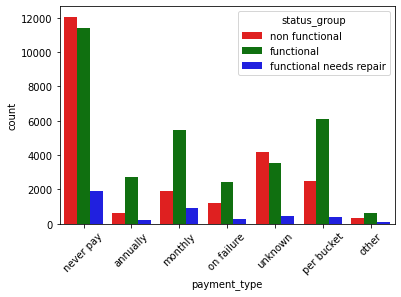

In [70]:
fig, ax = plt.subplots()
sns.countplot(x='payment_type', hue = 'status_group', data=df, ax=ax, palette=color_status)
plt.xticks(rotation=45)

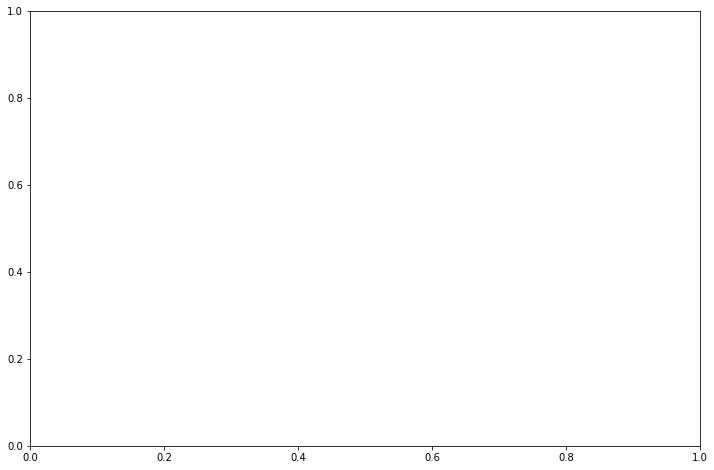

In [71]:
fig.ax = plt.subplots(figsize=(12,8))
sns.scatterplot(x='longitude', y='latitude', data=df, hue='status_group', ax=ax, palette=color_status)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

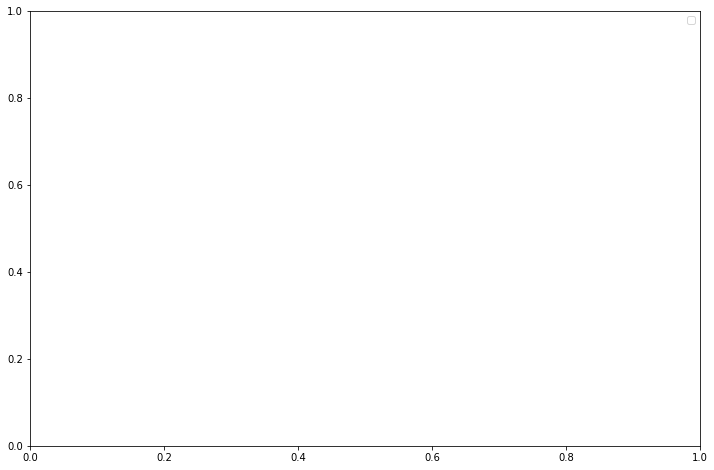

In [72]:
row_functional = (df['status_group'] == 'functional')
row_non_functional = (df['status_group'] == 'non functional')
row_repair = (df['status_group'] == 'functional needs repair')
col = 'gps_height'
fig.ax = plt.subplots(figsize=(12,8))
sns.distplot(df[col][row_functional], color = 'green', label='functional', ax=ax)
sns.distplot(df[col][row_non_functional], color = 'red', label='non functional', ax=ax)
sns.distplot(df[col][row_repair], color = 'blue', label='functional needs repair', ax=ax)
plt.legend()

**And then, we'll take a look at the first 20 rows of one of the files**

As mentioned earlier, `gunzip` is a decompression tool. The `-c` means to print out the result rather than write it to a file. The `|`, or pipe symbol, is used to pass the output of one command as the input to another command. In this case, we're using `head -20` to print the first 20 lines of the decompressed data.

Make sure to take a look at the contents of the data and notice that the separator used in this file is a tab character rather than a more traditional comma. 

In [ ]:
!gunzip -c /tmp/netflix_titles_dirty_03.csv.gz | head -20

## **Loading our initial DataFrame**

Let's take a look at what Spark does with our data and see if it can properly parse the output. To do this, we'll first load the content into a DataFrame using the `spark.read.csv()` method. 

We'll pass in three arguments:

 - The path to the file(s)
 - An entry for `header=False`. Our files do not have a header row, so we must specify this or risk a data row being interpreted as a header.
 - The last argument we add is the `sep` option, which specifies the field separator. Often in CSV files this is a comma (`,`), but in our files it's a `\t` or tab character.

In our command, we'll be using the wildcard character, `*`, again to access all the files matching `/tmp/netflix_titles_dirty*.csv.gz` (ie, all the files we've downloaded thus far). Spark will handle associating all the files to the same dataframe. 

Depending on how familiar you are with Spark, you should note that this line does not actually read the contents of the files yet. This command is *lazy*, which means it's not executed until we request Spark to execute some type of analysis. This is a crucial point to understand how data processing behaves within Spark. 

In [ ]:
# Read csv file wiith spark.read_csv()


## **Initial analysis**

Let's look at the first 150 rows using the `.show()` method on the DataFrame. We'll pass in:

- The number of rows to display (`150`)
- Set the `truncate` option to `False` so we can see all the DataFrame columns and content.

*Note: `.show()` is a Spark action, meaning that any previous lazy commands will now be executed prior to the actual action. Spark can also optimize these commands for best performance as needed.*



In [ ]:
# Show first 150 rows



**Problem 1**: First column contains a mix of numeric and string data.


We can also use the `.printSchema()` method to print the inferred schema associated with the data. Notice that we have 12 columns (which is expected based on our format information) but there are no column names, incorrect datatypes, and each field is nullable. *Note: `.printSchema()` is also a Spark action.*

**Problem 2**: Column names are generic.

**Problem 3**: All columns are typed as strings, but appear to contain various datatypes (also reference **problem 1**)

In [ ]:
# Print schema


## **Bypassing the CSV interpeter**

Our first few data rows look ok, but we can see that we have a few random rows even in our small sample. We know the first column should be an integer value but it looks like there are some values that do not meet this requirement. 

Let's run a `.count()` method on our dataframe to determine how many rows are present in the dataset, regardless of whether they're correct.


In [ ]:
# Count the number of rows



 Let's run a quick select statement on the DataFrame to determine the makeup of the content. We'll use some methods from the `pyspark.sql.functions` module to help us determine this. We'll alias this module as `F` for simplicity.

We're going to use the `F.col` method to find the column named `_c0` in our dataframe. We'll then chain the function `.cast("int")` to attempt to change each entry from a string value to an integer one. We then use the `.isNotNull()` function to find only entries that are not null. This is passed to the the `.filter()` method on the dataframe to return only rows that meet this requirement. Finally we run the `.count()` method on the resulting dataframe to get the count of rows where the first column is an integer value.

An example to filter a Spark dataframe named `df_1` with a column named `_c0` would be:

```
from pyspark.sql import functions as F

df_1.filter(F.col("_c0").cast("int").isNotNull()).show()
```


In [ ]:
# Import the Pyspark SQL helper functions


# Determine how many rows have a column that converts properly to an integer value



### **Spark is different**

Depending on your background, you may be very confused as to what's going on right now. If you're used to pandas, you should know that Spark behaves similarly, but there are some significant differences.

#### **Spark dataframes are immutable**
- This means that once a dataframe is created, you cannot change the contents of the dataframe, you can only create a new one.
- We won't cover why during this class, beyond mentioning that it makes a distributed system (such as Spark) much more manageable.
- While you cannot change a dataframe, you can create a new one.
- Dataframes in Spark are defined with various types of *transformations*. These are the *lazy* commands we mentioned earlier. You can think of them as a recipe, or set of commands that will be run at a given time. 
- Spark *actions* (such as `.count()`, `.show()`, `.write()`, among others) instantiate the dataframe, meaning that the data is processed and available within the dataframe.

The important thing to note is that these `.filter()` commands are not changing our underlying dataframe - it's creating a new dataframe with the results of the `.filter()` operation and giving us the `.count()` of that. This is all done behind the scenes for you, but it's important to understand what Spark is doing underneath.

### **Back to analysis**

Now that we've determined there is a difference between the number of correct entries vs all entries (ie, take the full count and subtract the filtered dataframe), let's look at the rows that aren't coverting properly.

We'll do the same as before, but this time we're going to use the `.isNull()` method to obtain only the rows that can't be cast to integers. We'll use the `.show()` method to see the content.

*Note, this is only possible because Spark maintains an immutable dataframe. In our previous step, we created a new dataframe from our `.filter()` command, ran an action, and then Spark threw away the dataframe as we didn't assign it to a variable. We're going to now do the same type of operation on the original `titles_df` dataframe.*

In [ ]:
# Look at rows that don't convert properly


*Data problems*:
- **Problem 4**: Comment rows - These begin with a `#` character in the first column, and all other columns are null
- **Problem 5**: Missing first column - We have few rows that reference `TV Show` or `Movie`, which should be the 2nd column.
- **Problem 6**: Odd columns - There are a few rows included where the columns seem out of sync (ie, a content type in the ID field, dates in the wrong column, etc).

We could fairly easily remove rows that match this pattern, but we're not entirely sure what to expect here. This is a common issue when trying to parse a large amount of data, be it in native Python, in Spark, or even with command-line tools. 

What we need to do is bypass most of the CSV parser's intelligence, but still load the content into a DataFrame. One way to do this is to modify an option on the CSV loader.

# **CSV loading**

Our initial import relies on the defaults for the CSV import mechanism. This typically assumes an actual comma-separated value file using `,` between fields and a normal row level terminator (ie, `\r\n`, `\r`, `\n`). While this often works well, it doesn't always handle ever data cleaning process you'd like, especially if you want to save the errant data for later examination.

One way we can trick our CSV load is to specify a custom separator that we know does not exist within our dataset. As we used above, the option to do this is called `sep` and takes a single character to be used as the column separator. The separator cannot be an empty string so depending on your data, you may need to determine a character that is not used. For our purposes, let's use a curly brace, `{`, which is most likely not present in our data.

In [ ]:
# Load the files into a DataFrame with a single column


In [ ]:
# Count rows


In [ ]:
# Show header


In [ ]:
# Print schema



# **Q&A?**

# **Cleaning up our data**

We know from some earlier analysis that we have comment rows in place (ie, rows that begin with a `#`). While Spark provides a DataFrame option to handle this automatically, let's consider what it would take to remove comment rows.

We need to:

- Determine if the column / line starts with a `#`
- If so, filter these out to a new DataFrame

There are many ways to accomplish this in Spark, but let's use a conceptually straight-forward option, `.startsWith()`.

In [ ]:
# Filter DataFrame and show rows that starts with #


In [ ]:
# Count number of rows



47

We've determined that we have 47 rows that begin with a comment character. We can now easily filter these from our DataFrame as we do below. This resolves **Problem 4**.

*Note: We're doing things in a more difficult fashion than is absolutely necessary to illustrate options. The Spark CSV reader has an option for a `comment` property, which actually defaults to skipping all rows starting with a `#` character. That said, it only supports a single character - consider if you were looking for multi-character options (ie, a // from C-style syntax). This feature is also only available in newer versions of Spark, where our method works in any of the 2.x Spark releases.*

In [ ]:
# Filter out comments



# **Checking column counts**

Our next step for cleaning this dataset in Pyspark involves determining how many columns we should have in our dataset and take care of any outliers. We know from our earlier examination that the dataset should have 12 usable columns per row.

First, let's determine how many columns are present in the data and add that as a column. We'll do this with a combination of:

- `F.split()`: This acts similar to the Python `split()` method, splitting the contents of a dataframe column on a specified character into a Spark ArrayType column (ie, Spark's version of a list variable). 
- `F.size()`: Returns the size (length) of a Spark ArrayType column.
- `.withColumn()`: Creates a new dataframe with a given column.

In [ ]:
# Add a column representing the total number of fields / columns



In [ ]:
# Show rows with a fieldcount > 12 (Note, select statement here isn't necessarily required - used to reorder the columns for easier viewing)


In [ ]:
# Check for any rows with fewer than 12 columns



**Problem 7**: Column counts do not match our expected schema.

In [ ]:
# Save these to a separate dataframe for later analysis



In [ ]:
# Determine total number of "bad" rows


We can now resolve **problems 5, 6, and 7** by accessing only the rows that have 12 columns present.

In [ ]:
# Set the dataframe without the bad rows


In [ ]:
# How many current rows in dataframe?



# **Q&A**

# **More cleaning / prep**

Now that we've removed rows that don't fit our basic formatting, let's continue on with making our dataframe more useful.

First, let's create a new column that is a list (actually a Spark ArrayType column) containing all "columns" using the `pyspark.sql.functions.split` method. We'll call this `splitcolumn`.

In [ ]:
# Create a list of split strings as a new column named splitcolumn


In [ ]:
# View the contents


# **Creating typed columns**

There are several ways to do this operation depending on your needs, but for this dataset we'll explicitly convert the strings in the ArrayType column (ie, a Spark list column) to actual dataframe columns. The `.getItem()` method returns the value at the specified index of the listcolumn (ie, of `splitcolumn`). 

Let's consider if we wanted to create a full dataframe from the following example dataframe (`df_1`):

splitcolumn |
---|
[1,USA,North America]
[2,France,Europe]
[3,China,Asia]

```
df_1 = df_1.withColumn('country_id', df_1.splitcolumn.getItem(0).cast(IntegerType())
df_1 = df_1.withColumn('country_name', df_1.splitcolumn.getItem(1))
df_1 = df_1.withColumn('continent', df_1.splitcolumn.getItem(2))
```

This would give you a resulting dataframe of:

splitcolumn | country_id | country_name | continent
---|---|---|---
[1,USA,North America]|1|USA|North America
[2,France,Europe]|2|France|Europe
[3,China,Asia]|3|China|Asia

The `splitcolumn` is currently still present - we'll take care of that later on.

Note that for `show_id` and `release_year`, we'll also use `.cast()` to specify them as integers rather than just strings. We also need to import the `IntegerType` from the `pyspark.sql.types` module to properly cast our data to an integer column in Spark.



In [ ]:
from pyspark.sql.types import IntegerType

# Create columns with specific data types using .getItem()


Let's now drop our columns that aren't needed anymore. These are `_c0` (the original single line string), `fieldcount`, and `splitcolumn`. You can drop these as a single column per entry, or a comma-separated set of column names.

In [ ]:
# Drop original _c0 column



Let's verify our content, check the row count, and then look at our schema.

In [ ]:
# Showcase new DataFrame



In [ ]:
# Count rows



In [ ]:
# Print the schema



# **Even more cleanup**

With our last set of steps, we've successfully fixed our remaining **problems (1, 2, and 3)**. Now that we have a generally clean dataset, let's look for further issues.

If we look at the distinct values available in the show `type` column, we see an issue. This is a categorical data column - collapsing the values in this column is a typical data cleaning issue.

In [ ]:
# Check out unique items in type column



In [ ]:
# Isolate rows where type is ""



You'll notice that we have 5 rows where the type is not specified when one should be. 

**Problem 8**: Invalid entry in a column - The type column should contain only `TV Show` or `Movie`, but it also contains an empty string value.


 We have a couple of options:

- Drop the rows
- Infer what the `type` is based on other content available in the dataset

You could remove the problem rows using something like:

```
titles_cleaned_df = titles_cleaned_df.where('type == "TV Show" or type == "Movie"')
```

That feels a bit like cheating though - let's consider how else we could determine this largely automatically.

If you look at the `duration` column, you'll notice that there are different meanings behind the entries. We have durations that contain the word *min* (minutes) or the word `Season` for seasons of the show. We can try to use these to properly set the `type` value for these rows.

This problem is a bit tricky though as Spark does not have the concept of updating data within a column without jumping through several hoops. We can however work through this issue using a User Defined Function, or UDF.

## **UDF**

If you haven't worked with them before, a UDF is a Python function that gets applied to every row of a DataFrame. They are extremely flexible and can help us work through issues such as our current one.

A UDF in Pyspark requires three things:

1. **A Python function or callable**: This is the function that you want called when the UDF is run by Spark.
2. **A UDF variable**: Defined by the `udf()` function, with the Python callable defined in #1, and the Spark return type.
3. **A Spark transformation**: The UDF must be defined via a transformation (ie `.withColumn()`) to be applied to the dataframe.

Consider the following dataframe `df_1`, containing a two fields, `a` and `b`

a|b
---|---
1|2
2|3
3|4

For illustration, let's say we want to use a UDF to define a new column, which is simply the value `a*b`, unless the value of `a` is `3`. If it is, then we want the value to be `0`.

Let's define our function - taking two arguments, `a`, and `b`. 

```
def multiply(a, b):
  if a == 3:
    return 0
  else:
    return a*b
```

Now, we need to define our UDF variable. We need to import `udf` from `pyspark.sql.functions`, and as we're returning an integer value, we need to import `IntegerType` from `pyspark.sql.types`. 

```
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

udfMultiply = udf(multiply, IntegerType())
```

Note that the `udf` function only takes the name of the callable, not any arguments. Those are defined with our last step - defining a new column. 

```
df_1 = df_1.withColumn('output', udfMultiply(F.col('a'), F.col('b')))
```

Note that in this instance we're using the `F.col` method to refer to the column. You could use any of the other valid Spark methods to specify a dataframe column (ie, `df_1.a`, `df_1['b']`, etc).

Assuming we run a Spark action, such as `.show()`, we would get a dataframe with the following contents:

a|b|output
---|---|---
1|2|2
2|3|6
3|4|0

*Note this is a trivial example for illustration purposes - the same behavior would be much better implemented using assorted functions in the Spark libraries.*


First, let's define our Python function that takes two arguments, a showtype (ie, *Movie*, *TV Show*, or other) and the showduration. Note that these are strings in this case. We'll check if the showtype is already a Movie or TV Show - if so, just return that value. Otherwise, we'll check if the showduration ends with *min*, indicating a Movie. If not, we'll specify it as a TV Show.


In [ ]:
# Define the UDF callable


# **Define the UDF for Spark**

Now we need to configure the UDF for Spark to access it accordingly.

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType


In [ ]:
# Create a new derived column, passing in the appropriate values



In [ ]:
# Show the rows where type is an empty string again, examining the derivedType


In [ ]:
# Drop the original type column and rename derviedType to type


In [ ]:
# Verify we only have two types available


In [ ]:
# Verify our row count is the same


We've now successfully resolved **problem 8**.

# **Saving data for analysis / further processing**

The last step of our data cleaning is to save the cleaned dataframe out to a file type. If you plan to do any further analysis or processing using Spark, it's highly recommended you use Parquet. Other options are available per your needs, but Spark is optimized to take advantage of Parquet.

There are two options we use for the `.write.parquet()` method:

- The path of where to write the file
- An optional `mode` parameter, which we've set to `overwrite`. This allows Spark to write data to an existing location, solving some potential issues in a notebook environment.

In [ ]:
# Save the data


Let's now take a look at the contents using the `ls` shell command. You'll notice that the `/tmp/netflix_titles_cleaned.parquet` location is actually a directory, not just a file. This is due to the way Spark handles its data allocation and formatting. More on this in a minute.

In [ ]:
# Is file in directory?


Note that typically when processing data in Spark, you'll want to use the Parquet format as described above. This is great for any further processing or analysis you plan to do in Spark. However, it can be difficult to read Parquet files outside of Spark without extra work. As such, let's create a version in CSV format that you can download if you desire.

We'll need to do four steps for this operation:

- Combine the data into a single file using the `.coalesce(1)` transformation. Spark normally keeps data in separate files to improve performance and bypass RAM issues. Our dataset is small and we can bypass those concerns.
- Use the `.write.csv()` method (instead of `.write.parquet()`). We'll also add an extra option of `sep='\t'` to bypass the issue of commas being present in our data. We also have to define a `header=True` component so our columns are named correctly.
- Rename the file to something usable with a shell command `mv`. Spark stores files named via their partition id. We need to rename that to something more recognizable.
- Finally, we'll use a special command specific to the notebook environment to download the file.

As you've seen within Spark, you can chain commands together. As such, we'll combine the first two components.

In [ ]:
# Coalesce and save the data in CSV format

titles_cleaned_df.coalesce(1).write.csv('/tmp/netflix_titles_cleaned.csv', mode='overwrite', sep='\t', header=True)

In [ ]:
# Look at the output of the command using the shell command `ls`

!ls /tmp/netflix_titles_cleaned.csv

part-00000-5f404d8b-c020-478e-856d-76999184e063-c000.csv  _SUCCESS


In [ ]:
# Rename the data file

!mv /tmp/netflix_titles_cleaned.csv/part-00000*.csv /tmp/netflix_titles_cleaned_final.csv

In [ ]:
# Download the file via notebook tools

from google.colab import files
files.download('/tmp/netflix_titles_cleaned_final.csv')

# **Challenges**

We've looked at several data cleaning operations using Spark. Here are some other challenges to consider within the dataset:

1) *Splitting names* - 
  You may have noticed that the names are combined for the cast and directors into a list. Consider how you would turn that data into a list / array column to easily access more detailed information (which shows have the largest cast, etc?)

2) *Splitting names further* - Consider taking any of the name fields and splitting it into first name, last name, etc. Take special consideration about how you would handle initials, names with more than 3 components, etc.

3) *Parsing dates* - Look at the `date_added` field and determine if and how you could reliably convert this to an actual datetime field.

# **Last Q&A**